## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


A/B tests are very commonly performed in data analysis and in data science.The main goal of this project was to understand the results of an A/B test run by the website and provide statistical and practical interpretation on the test results, to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Part I - Probability

import the libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b.Find the number of rows in the dataset.

In [3]:
# use shape to find number of rows
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
treat_old = df[(df.group == 'treatment') & (df.landing_page == 'old_page')]
treat_old.shape[0]

1965

In [7]:
ctl_new = df[(df.group == 'control') & (df.landing_page == 'new_page')]
ctl_new.shape[0]

1928

In [8]:
treat_old.shape[0] + ctl_new.shape[0]

3893

f. Do any of the rows have missing values?

In [9]:
# check if any null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**Answer**:There are no rows with missing values in the dataset.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a.Store your new dataframe in **df2**.

In [10]:
# Filtering the Dataframe so that it only includes the correct allignments:
df2 = df.query('landing_page == "new_page" & group == "treatment"')
df2 = df2.append(df.query('landing_page == "old_page" & group == "control"'))

In [11]:
df2.shape

(290585, 5)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()


290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
sum(df2.user_id.duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2 = df2[~df2.user_id.duplicated(keep='first')]

In [17]:
sum(df2.user_id.duplicated())

0

In [18]:
df2.shape

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
control_convert = df2.query('group == "control"')
control_convert.converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
treatment_convert = df2.query('group == "treatment"')
treatment_convert.converted.mean() 

0.11880806551510564

d. What is the probability that an individual received the new page?

In [22]:
p_new_page = (df2['landing_page'] == 'new_page').mean()
p_new_page

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Answer** It appears that individuals in the treatment group had a conversion rate of 11.88% and individuals in the control group had a conversion rate of 12.04%.These results suggest that there is not sufficient evidence to say that the treatment page leads to more conversions as the probability of conversion for the treatment group is less than that for the control group, but the difference appears to be negligible.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer.**

$H_0:$ $p_{new}$≤$p_{old}$

$H_1:$ $p_{new}$> $p_{old}$

or

$H_0:$ $p_{new}$-$p_{old}$≤ 0
 
$H_1:$ $p_{new}$-$p_{old}$> 0
 
 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$?

In [25]:
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new

145310

d. What is $n_{old}$?

In [26]:
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
 # simulate under null for n_new
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
new_page_converted.mean()

0.1191796848117817

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
# simulate under null for n_old
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
old_page_converted.mean()

0.11957404628495119

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
# differences computed in from p_new and p_old
obs_diff= new_page_converted.mean() - old_page_converted.mean()
obs_diff  

-0.00039436147316948555

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
# Create a sampling distribution of the difference in proportions
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [31]:
p_diffs = np.asarray(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5, 0, 'Probability Difference')

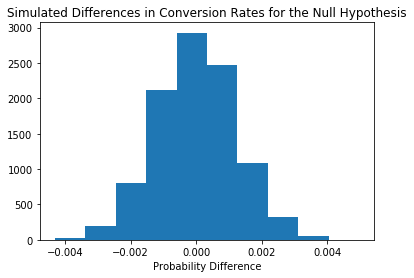

In [32]:
plt.hist(p_diffs)
plt.title('Simulated Differences in Conversion Rates for the Null Hypothesis')#title of graphs
plt.xlabel('Probability Difference') # x-label of graphs

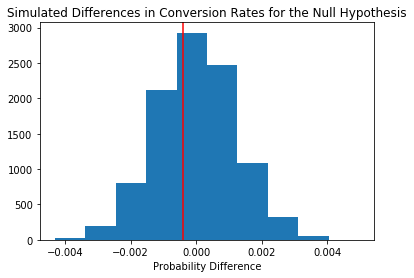

In [33]:
plt.hist(p_diffs);
plt.title('Simulated Differences in Conversion Rates for the Null Hypothesis') #title of graphs
plt.xlabel('Probability Difference') # x-label of graphs
plt.axvline(obs_diff, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
actual_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
actual_diff

-0.0015782389853555567

In [35]:
# compute p-value
(np.array(p_diffs) > actual_diff).mean()

0.9043

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**

The p-value in this study is 90%. In the majority of analyses, an alpha of 0.05 is used as the cutoff for significance. In this analysis, the p-value is larger than 0.05 and we therefore, we would fail to reject the null hypothesis and conclude that there is not sufficient evidence to say that that there is a difference between the the old and new pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [36]:
import statsmodels.api as sm

converted_old = len(df2[df2.landing_page == 'old_page'][df2.converted == 1])
converted_new = len(df2[df2.landing_page == 'new_page'][df2.converted == 1])
n_old = len(df2[df2.landing_page == 'old_page'])
n_new = len(df2[df2.landing_page == 'new_page'])
#n_new
converted_old, converted_new, n_old, n_new



/Users/njood/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/njood/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [37]:
z_score, p_value = sm.stats.proportions_ztest([converted_new, converted_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [38]:
from scipy.stats import norm
norm.cdf(z_score)

0.09494168724097551

In [39]:
#critical value at 95% confidence is
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer.**
 Since the z-value does not exceed the critical value at 95% confidence - which is 1.96, we fail to reject the null hypothesis.
The p-value of 0.90 is larger than 0.05 and so we also fail to reject the null hypothesis using the p-value.





<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer.**
 
We are dealing with binary variables, Logistic regression should be used.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [40]:
#adding an intercept column
df2['intercept'] = 1

#Create dummy variable column
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [41]:
#import statsmodels.api as sm
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        11:48:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer.**

The p-value calculated here is 0.190. This is because the Logit Regression is based on a two-tailed test. 0.190 is still greater then 0.05 alpha, so we still cannot reject our null hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer.**

At this point, why one of the webpages might be more successful than the other one is due to change aversion and the novelty effect. While change aversion might lead to users have trouble adapting to the new webpage due to prior experiences, the novelty effect will have the opposite effect of favouring anything new regardless of objectively better features. These issues can be fixed by extending the testing time.The advantages of considering other factors to add into my regression model is that we would be able to find out other factors that may influence why a person converts or does not convert.The convert rate may be related to some features of users like nationality, age, gender or specific cultural behavior. Adding additional information about users could reveal hidden value of the new version of the page for specific group of the users.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [43]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [44]:
# Check what countries are in the new dataset.
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [45]:
### Create the necessary dummy variables
df_new[['CA', 'US', 'UK']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,US,UK
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [46]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 13 Jun 2020   Pseudo R-squ.:               1.521e-05
Time:                        11:48:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0408      0.027      1.518      0.129      -0.012       0.093
US             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

**Answer** The p-values for the countries are above 0.05, so again we cannot reject the null hypothesis. Countries do not influence significantly differences in the conversion rates.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:

# Create additional columns specifying what user/country converted اضافية
df_new['us_page'] = df_new['US'] * df_new['ab_page']
df_new['uk_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,CA,US,UK,us_page,uk_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,1,0


In [48]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'UK', 'us_page', 'uk_page']])
result = log_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 13 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        11:48:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US             0.0118      0.040      0.296      0.767      -0.066       0.090
UK             0.0175      0.038      0.465      0.642      -0.056       0.091
us_page        0.0783      0.057      1.378      0.168      -0.033       0.190
uk_page        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

**Answer** Looking at p-values for all variables (all higher than 0.05) we can say that interactions between page and country have no significant effects on conversion.

<a id='conclusions'></a>
## Conclusions

This project aimed to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision. With change of methodology between part II and part III, p-value changed. But in either case, we fail to reject the null as value is still higher than alpha. Based on this analysis, there is no practical significance in rolling out the new page over old page. Conversion rate for old page is better than new one. Comparing users among different countries also doesn't show considerable difference in statistics.The conclusion of the  result is that we do not have sufficient evidence to suggest that the new page results in more conversions than the old one.

